# Consumer Knowledge and Understanding

This section explores how consumer knowledge and understanding influence the adoption of electric vehicles (EVs) in France.
Survey data was analyzed to understand the relations between :

- **Self-assessed understanding**  
  (Perceived ease of use, clarity of practical aspects such as charging, autonomy, and maintenance)
- **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)
- **Objective and subjective knowledge**  
  (Self-rated knowledge of EV models and infrastructure, number of financial aids known)
- **Experience and familiarity with EVs**  
  (Driving or riding in an EV, practical understanding, perceived ease of use)
- **Link between knowledge/experience and adoption intent**  
  (Correlation between knowledge, experience, and willingness to adopt)
- **Influence of user profile**  
  (Differences in knowledge and experience by age group and location)

## Setup

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display

KeyboardInterrupt: 

In [ ]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [ ]:
df = pd.read_csv(r'c:\Users\Mango\Downloads\FinalEvAdoptionInFranceResults.csv')
for col in df.columns:
    values = df[col].dropna().astype(str)
    split_vals = []
    for val in values:
        split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
    unique_vals = pd.unique(split_vals)
    if len(unique_vals) <= 20:
        print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
        if len(unique_vals) > 20:
            print("... (troncature à 20 valeurs)")
        print("-" * 60)
print(list(df.columns))

C:\Users\Mango\AppData\Local\Temp\ipykernel_43280\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_43280\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_43280\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(split_vals)
C:\Users\Mango\AppData\Local\Temp\ipykernel_43280\507991816.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_vals = pd.unique(

Colonne: Combien êtes-vous dans votre foyer ?
Réponses possibles (10): ['4' '2' '5' '1' '3' '6' '9' '7' '8' '11']
------------------------------------------------------------
Colonne: Habitez-vous dans :
Réponses possibles (4): ['Une ville moyenne' 'Une grande ville' 'Une zone périurbaine'
 'Une zone rurale']
------------------------------------------------------------
Colonne: Avez-vous accès à une place de parking personnelle ?
Réponses possibles (4): ['Oui'
 "avec borne de recharge ou possibilité d'en installer une (à domicile ou en résidence par exemple)"
 'Non' "sans borne de recharge ou possibilité d'en installer une"]
------------------------------------------------------------
Colonne: Combien de véhicules personnels utilisez-vous dans votre foyer ?
Réponses possibles (7): ['2' '0' '1' '3' '4' '7' '5']
------------------------------------------------------------
Colonne: Pourquoi n'avez-vous pas de véhicule ?

Réponses possibles (7): ["Je n'ai pas de permis de conduire"
 'Je vi

KeyboardInterrupt: 

## **Self-assessed understanding**  
  (Perceived ease of use, clarity of practical aspects such as charging, autonomy, and maintenance)

In [ ]:
# 1. Statistiques descriptives sur la compréhension auto-déclarée
comprehension_cols = [
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]",
]
# 1. Extraction des types de bornes connues (multi-réponses)
bornes_col = "Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?"
df[bornes_col] = df[bornes_col].astype(str)
# Oui, c'est utile ici pour extraire toutes les modalités uniques de bornes connues
all_answers = df[bornes_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers = [item for sublist in all_answers for item in sublist]
modalites = sorted(set(flat_answers))
# Création de colonnes binaires pour chaque modalité
for mod in modalites:
    df[f"borne_{mod}"] = df[bornes_col].str.contains(mod, regex=False).astype(int)

# Statistiques descriptives
for mod in modalites:
    print(f"{mod} : {df[f'borne_{mod}'].mean()*100:.1f}% des répondants")

# Croisement avec la localisation
geo_col = "Habitez-vous dans :"
for mod in modalites:
    cross = pd.crosstab(df[geo_col], df[f"borne_{mod}"], normalize='index')
    print(f"\nRépartition '{mod}' par zone :")
    print((cross*100).round(1))
for col in comprehension_cols:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))
    # Map Likert responses to numeric if needed
    if df[col].dtype == object:

        col_num = df[col].map(likert_map)
    else:
        col_num = df[col]
    print(f"Moyenne: {col_num.mean():.2f} | % d'accord (>=4): {(col_num>=4).mean()*100:.1f}%")
    

Non : 23.7% des répondants
Oui : 77.2% des répondants
des bornes "privées" (Supermarché : 51.3% des répondants
des bornes publiques : 47.4% des répondants
je n'en vois pas : 23.7% des répondants
lieu de travail...) : 51.3% des répondants
résidence...) : 19.4% des répondants
à domicile (maison : 19.4% des répondants

Répartition 'Non' par zone :
borne_Non                0     1
Habitez-vous dans :             
Une grande ville      72.6  27.4
Une ville moyenne     77.1  22.9
Une zone périurbaine  76.6  23.4
Une zone rurale       83.9  16.1



Répartition 'Oui' par zone :
borne_Oui                0     1
Habitez-vous dans :             
Une grande ville      27.4  72.6
Une ville moyenne     21.4  78.6
Une zone périurbaine  21.3  78.7
Une zone rurale       16.1  83.9

Répartition 'des bornes "privées" (Supermarché' par zone :
borne_des bornes "privées" (Supermarché     0     1
Habitez-vous dans :                                
Une grande ville                         54.8  45.2
Une ville moyenne                        48.6  51.4
Une zone périurbaine                     36.2  63.8
Une zone rurale                          51.6  48.4

Répartition 'des bornes publiques' par zone :
borne_des bornes publiques     0     1
Habitez-vous dans :                   
Une grande ville            56.0  44.0
Une ville moyenne           48.6  51.4
Une zone périurbaine        55.3  44.7
Une zone rurale             48.4  51.6

Répartition 'je n'en vois pas' par zone :
borne_je n'en vois pas     0     1
Habitez-vous dans :               
Une gr

## **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)

In [ ]:
for col in comprehension_cols:
    print(f"\n{col}")
    for mod in modalites:
        mean = df.groupby(f"borne_{mod}")[col].value_counts(normalize=True)
        print(f"  {mod} :\n{mean}")


Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?
 [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
  Non :
borne_Non  Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
0          Plutôt d'accord                                                                                                                                                                              0.572414
           Tout à fait d'accord                                                                                                                                                                         0.337931
           Plutôt en désaccord                                                                                                                                                                 

In [ ]:
# 4. Analyse du classement des facteurs
priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
from collections import Counter

# Extraction du facteur cité en premier
first_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[0].strip())
print("Facteur cité en 1ère priorité :")
print(first_factors.value_counts())

# Extraction du facteur cité en 2ème priorité
second_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[1].strip() if len(x.split(","))>1 else None)
print("\nFacteur cité en 2ème priorité :")
print(second_factors.value_counts())

Facteur cité en 1ère priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           85
Plus de recharge rapide                  55
Uniformisation des connecteurs           43
Centralisation des infos (application    24
Paiement simplifié                       13
Meilleure maintenance du réseau          12
Name: count, dtype: int64

Facteur cité en 2ème priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           50
Plus de recharge rapide                  50
Centralisation des infos (application    33
Uniformisation des connecteurs           32
prix                                     24
Paiement simplifié                       23
Meilleure maintenance du réseau          20
Name: count, dtype: int64


## **Objective and subjective knowledge**  
  (Self-rated knowledge of EV models and infrastructure, number of financial aids known)

## **Experience and familiarity with EVs**  
  (Driving or riding in an EV, practical understanding, perceived ease of use)


--- Analyse pour prise en main ---
Corrélation score ↔ intention d'adopter : r = 0.18, p = 0.0715


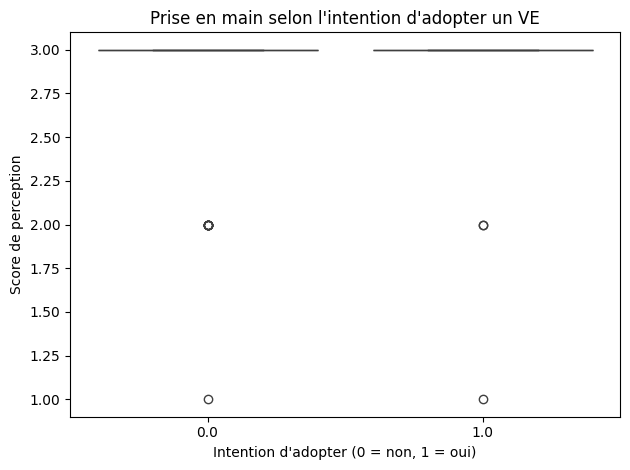

Pas assez de données pour le test d'expérience de conduite.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.87
Name: prise_en_main_score, dtype: float64

--- Analyse pour aspects pratiques ---
Corrélation score ↔ intention d'adopter : r = 0.34, p = 0.0001


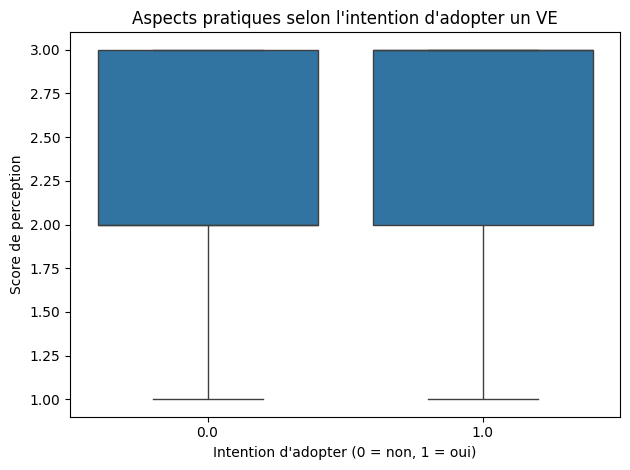

Pas assez de données pour le test d'expérience de conduite.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.48
Name: aspects_pratiques_score, dtype: float64


In [ ]:

# 1. Colonnes de perception (Likert)
info_cols = {
    "prise_en_main": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "aspects_pratiques": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]"
}

# 2. Intention d'adopter un VE
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
intention_map = {
    "Oui": 1, "Plutôt d'accord": 1, "Totalement d'accord": 1,
    "Non": 0, "Plutôt en désaccord": 0, "Totalement en désaccord": 0
}

# 3. Expérience de conduite
drive_exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
drive_exp_map = {
    "Oui, j’ai conduit": 1,
    "Oui, j’étais passager": 1,
    "Non": 0
}

# 4. Recodage des Likert
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
}

# 5. Recodage
df['intention_adopter'] = df[intention_col].map(intention_map)
df['has_driven_ev'] = df[drive_exp_col].map(drive_exp_map)

for key, col in info_cols.items():
    df[f"{key}_score"] = df[col].map(likert_map)

# 6. Analyse logique et complète
for key in info_cols:
    score_col = f"{key}_score"
    print(f"\n--- Analyse pour {key.replace('_', ' ')} ---")
    # Corrélation avec intention
    valid = df[[score_col, 'intention_adopter']].dropna()
    if not valid.empty:
        r, p = pearsonr(valid[score_col], valid['intention_adopter'])
        print(f"Corrélation score ↔ intention d'adopter : r = {r:.2f}, p = {p:.4f}")
    # Boxplot
    sns.boxplot(x='intention_adopter', y=score_col, data=df)
    plt.title(f"{key.replace('_', ' ').capitalize()} selon l'intention d'adopter un VE")
    plt.xlabel("Intention d'adopter (0 = non, 1 = oui)")
    plt.ylabel("Score de perception")
    plt.tight_layout()
    plt.show()
    # Test de normalité
    group1 = df[df['has_driven_ev'] == 1][score_col].dropna()
    group0 = df[df['has_driven_ev'] == 0][score_col].dropna()
    if len(group1) > 2 and len(group0) > 2:
        stat1, p1 = shapiro(group1)
        stat0, p0 = shapiro(group0)
        print(f"Normalité (expérience): p={p1:.3f} | (pas d'expérience): p={p0:.3f}")
        # Test de variance
        var1, var0 = np.var(group1), np.var(group0)
        print(f"Variance (expérience): {var1:.2f} | (pas d'expérience): {var0:.2f}")
        # Test de Student ou Mann-Whitney selon normalité
        if p1 > 0.05 and p0 > 0.05:
            t, p = ttest_ind(group1, group0, equal_var=False)
            test_used = "t-test"
        else:
            t, p = mannwhitneyu(group1, group0, alternative='two-sided')
            test_used = "Mann-Whitney"
        print(f"{test_used} : stat = {t:.2f}, p = {p:.4f}")
        # Effet taille (Cohen's d)
        d = (group1.mean() - group0.mean()) / np.sqrt((var1 + var0) / 2)
        print(f"Effet taille (Cohen's d) : {d:.2f}")
        # Interprétation automatique
        if p < 0.05:
            print("✅ Différence significative selon l'expérience de conduite d'un VE.")
        else:
            print("❌ Pas de différence significative selon l'expérience de conduite d'un VE.")
    else:
        print("Pas assez de données pour le test d'expérience de conduite.")
    # Moyennes
    print("Score moyen selon expérience de conduite :")
    print(df.groupby('has_driven_ev')[score_col].mean().round(2))

## **Link between knowledge/experience and adoption intent**  
  (Correlation between knowledge, experience, and willingness to adopt)

In [ ]:
# 3. Corrélation entre connaissance et attitude positive
from scipy.stats import pearsonr

valid = df[['connaissance_score', 'intention_adopter']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['intention_adopter'])
print(f"Corrélation connaissance <-> intention d'adopter : r = {r:.2f}, p = {p:.4f}")

# Comparaison par niveau de connaissance (faible/moyen/élevé)
df['niveau_connaissance'] = pd.cut(df['connaissance_score'], bins=[0,1.5,2.5,4], labels=['Faible','Moyen','Élevé'])
print(df.groupby('niveau_connaissance')['intention_adopter'].mean())

Corrélation connaissance <-> intention d'adopter : r = -0.03, p = 0.7171
niveau_connaissance
Faible    0.463415
Moyen     0.724638
Élevé     0.468085
Name: intention_adopter, dtype: float64


C:\Users\Mango\AppData\Local\Temp\ipykernel_42160\2736024798.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('niveau_connaissance')['intention_adopter'].mean())


In [ ]:
# Croisement classement 1er facteur x niveau de connaissance
cross = pd.crosstab(first_factors, df.loc[first_factors.index, 'niveau_connaissance'])
print("\nClassement du 1er facteur selon le niveau de connaissance :")
print(cross)


Classement du 1er facteur selon le niveau de connaissance :
niveau_connaissance                                 Faible  Moyen  Élevé
Classez ces points par priorité du plus crucial...                      
Centralisation des infos (application                    6      8     10
Meilleure maintenance du réseau                          5      3      4
Paiement simplifié                                       4      3      6
Plus de bornes                                          19     36     30
Plus de recharge rapide                                 15     23     17
Uniformisation des connecteurs                          11     21     11


## **Influence of user profile**  
  (Differences in knowledge and experience by age group and location)